для данной лабораторной работы необходимо установить 2 библиотеки
- tensorflow
- keras

In [2]:
!pip install tensorflow keras
# Если вам не повезло и tensorflow последней версии не устанавливается или не хочет работать, то надо поставить версию 1.5
# !pip install tensorflow==1.5

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
# подключение библиотек
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

### 1. Загрузка данных


При загрузки данных мы сразу же выбираем поле для индексации, это нужно для дальнейшего разделения данныех и удаления выбросов в обоих

In [4]:
import pandas as pd

data = pd.read_csv('titanic_train.csv', index_col='PassengerId')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Первым делом представим строковые данные как числовые
import sklearn.preprocessing as preprocessing

useful_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
data = data[useful_cols]

number_data = pd.get_dummies(data)
number_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,3,26.0,0,0,7.9250,1,0,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1
5,0,3,35.0,0,0,8.0500,0,1,0,0,1


### 2. Предварительная обработка данных  

Готовим наши данные для подачи на вход нейронной сети

In [37]:
# Пишем наши собственные препроцессоры

import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

У нас будет 2 pipeline'а:
1. Для входных данных
2. Для выходных

У входных и выходных данных будут общие следующие обработчики:
1. DropOutlet - наш класс для удаления выбросов
2. Конвертация из DataFrame в ndarray

*Препроцессор DropOutlet идет отдельно от всех других препроцессоров*


**Препроцессор для входных данных**:
1. Конвертация из DataFrame в ndarray
1. Нормализация с помощью препроцессора MinMaxScaler

**Препроцессор для выходных данных**:
1. Конвертация из DataFrame в ndarray
1. Преобразование из категорий в виде строк в числовой номер (1.2.3.4): ModifyLabelEncoder
1. Добавляем еще одну размерность для данных (нужно для следующего препроцессора): ExpandDims
1. Кодируем наши категории как вектор с одной 1 : OneHotEncoder  

In [7]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [8]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data[data.columns[:-1]].copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data[data.columns[0]].copy()

# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(821, 8) (821, 2)


In [9]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[0.        , 1.        , 0.37002318, 0.33333333, 0.        ,
         0.04397492, 0.        , 1.        ],
        [1.        , 0.        , 0.5638622 , 0.33333333, 0.        ,
         0.4323693 , 1.        , 0.        ],
        [1.        , 1.        , 0.41848293, 0.        , 0.        ,
         0.04806914, 1.        , 0.        ],
        [1.        , 0.        , 0.52751738, 0.33333333, 0.        ,
         0.32207838, 1.        , 0.        ],
        [0.        , 1.        , 0.52751738, 0.        , 0.        ,
         0.04882733, 0.        , 1.        ],
        [0.        , 1.        , 0.80908601, 0.        , 0.        ,
         0.05130387, 0.        , 1.        ],
        [0.        , 0.        , 0.75770122, 0.        , 0.        ,
         0.31457232, 0.        , 1.        ],
        [0.        , 1.        , 0.1277244 , 1.        , 0.5       ,
         0.12783054, 0.        , 1.        ],
        [1.        , 1.        , 0.43059787, 0.        , 1.        ,
         0.

Как можно видеть выше мы получили на выходе многомерный массив. именно его и мы будем в дальнейшем подавать на вход для алгоритмов машинного обучения

### 3. Построение простой нейронной сети

In [10]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape


((821, 8), (821, 2))

#### Подключаем библиотеку keras


```Python
from keras.layers import Dense
```
Строка отвечает за подключение сущности Dense которая реализует простой полносвязные слой сети (FFN)

```Python
from keras.models import Sequential
```
Строка отвечает за подключение сущности Sequential которая реализует саму нейронную сеть

```Python
from keras import activations
```
Это импорт (activations) содержи в себе список функций активании для сети

```Python
from keras.optimizers import Adam, RMSprop
```
Тут мы подключаем алгоритмы тренировки Адам и алгоритм обратного распостранения ошибки(RMSprop)

```Python
from keras.losses import categorical_crossentropy
```
Подключаем фукцию подсчета ошибки сети (кросэтропися для данных представленных в виде категорий)

```Python
from keras.metrics import categorical_accuracy
```
Подключаем фукцию подсчета метрики сети (точность попадания в категорию)

In [11]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

#### Создаем сеть
```Python
model = Sequential()
```
Создаем сущность сети

```Python
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
```
Добавляем слой сети из 10 нейронов с функцией активации Relu и количеством входом равным количеству столбцов во входном массиве

```Python
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3
```
Добавляем последний слой(выходной) количество нейронов равно количеству столбцов в выходном массиве и функцией активации Softmax 

```Python
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
```
Компилируем (собираем) сеть с параметрами:
- алгоритм обучения: *Adam*
- Функция обибки: *categorical_crossentropy*
- дополнительные метрики:
    - categorical_accuracy

In [12]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1])) # input_dim = 4
model.add(Dense(Y_train.shape[1], activation=activations.softmax)) # output = 3

model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

### 4. Обучение
Запускаем оучение сети с параметрами:
- 1 параметр: матрица с входным массивом
- 2 параметр: матрица с требуемыми ответами (выходная матрица)
- verbose=2 : устанавливаем уровень вывода отладочной информации на 2 уровень
- epochs=100 : задаем количество эпох для обучения (100 для начала более чем достаточно)
- batch_size=3 : размер группы для обучения (пакетный метод), гду говоря как часто пересчитывать веса сети (влияет на скорость и что более важно на качество обучения (параметр подбирается опытным путем) )

In [13]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 2s - loss: 0.6002 - categorical_accuracy: 0.7040
Epoch 2/100
 - 0s - loss: 0.2382 - categorical_accuracy: 0.9781
Epoch 3/100
 - 0s - loss: 0.0892 - categorical_accuracy: 1.0000
Epoch 4/100
 - 0s - loss: 0.0372 - categorical_accuracy: 1.0000
Epoch 5/100
 - 0s - loss: 0.0188 - categorical_accuracy: 1.0000
Epoch 6/100
 - 0s - loss: 0.0110 - categorical_accuracy: 1.0000
Epoch 7/100
 - 0s - loss: 0.0071 - categorical_accuracy: 1.0000
Epoch 8/100
 - 0s - loss: 0.0049 - categorical_accuracy: 1.0000
Epoch 9/100
 - 0s - loss: 0.0036 - categorical_accuracy: 1.0000
Epoch 10/100
 - 0s - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 11/100
 - 0s - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 12/100
 - 0s - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 13/100
 - 0s - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 14/100
 - 0s - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 15/100
 - 0s - loss: 8.1051e-04 - categorical_accuracy: 1.0000
Epoch 16/100
 - 0s - loss: 6.6

Посчитаем точность сети (1 цифра показывает ошибку сети, 2 метрику (точность) )

In [15]:

model.evaluate(X_train, Y_train)

821/821 [==============================] - 0s 12us/step


[1.193544896598565e-07, 1.0]

## 5. Построение усложненого варианта НС с делением данных на обучающую и тестовую выборку с визуализацие процесса обучения

In [16]:
# Подключим новые библиотеки
# библиотека дополнительных возможностей (действий) при обучении сети
from keras import callbacks

# Разделение на обучающую и тестовую выборки
Для полноценной оценки работы сети ее надо оценивать не только на тренировочной выборе (это наш 1 вариант сети), но и на тестовой (это та выборка которая никогда не подавалась на нейронную сеть)

In [17]:
# Делим
# Делить будем в отношении 80/20
# 80 - это обучение
# 20 - тест
# первым делом перемешаем выборку (надо для того что бы обе выборки были репрезентативными)
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для тренировки (входных): {X_train.shape}')
print(f'Размер данные для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данные для теста (входных): {X_test.shape}')
print(f'Размер данные для теста (выходных): {Y_test.shape}')

Всего данных: 821
Тренировочных данных: 657
Тестовых данных: 164
Размер данные для тренировки (входных): (657, 8)
Размер данные для тренировки (выходных): (657, 2)
Размер данные для теста (входных): (164, 8)
Размер данные для теста (выходных): (164, 2)


In [18]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dropout(0.5))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model


В обучение модели добавим проверку на тестовых данных, так же добавим наш первый callback - History: он просто сохраняет историю измерения ошибки и метрик по эпохам

In [24]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 657 samples, validate on 164 samples
Epoch 1/100
657/657 [==============================] - 1s 1ms/step - loss: 0.6394 - categorical_accuracy: 0.6484 - val_loss: 0.4709 - val_categorical_accuracy: 0.8354
Epoch 2/100
657/657 [==============================] - 0s 345us/step - loss: 0.4914 - categorical_accuracy: 0.7580 - val_loss: 0.3667 - val_categorical_accuracy: 0.8537
Epoch 3/100
657/657 [==============================] - 0s 299us/step - loss: 0.4117 - categorical_accuracy: 0.7945 - val_loss: 0.2699 - val_categorical_accuracy: 0.9390
Epoch 4/100
657/657 [==============================] - 0s 313us/step - loss: 0.3550 - categorical_accuracy: 0.8463 - val_loss: 0.2047 - val_categorical_accuracy: 0.9817
Epoch 5/100
657/657 [==============================] - 0s 308us/step - loss: 0.2998 - categorical_accuracy: 0.8782 - val_loss: 0.1514 - val_categorical_accuracy: 1.0000
Epoch 6/100
657/657 [==============================] - 0s 308us/step - loss: 0.2605 - ca

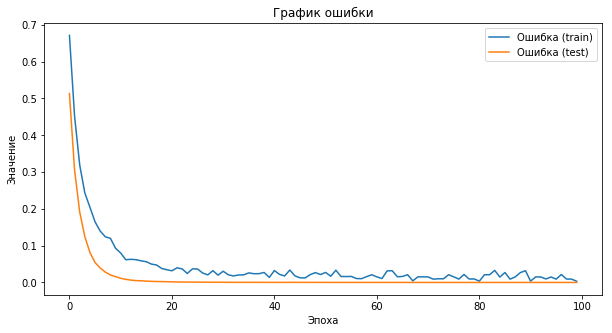

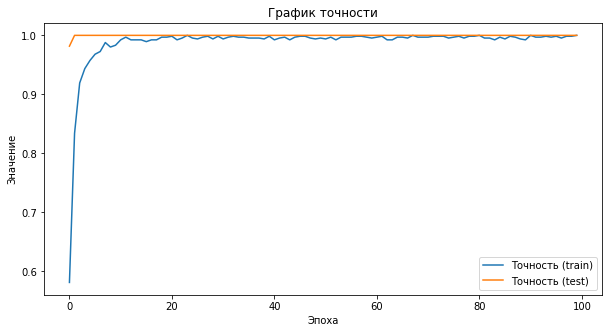

In [20]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

На самом деле в keras все готово для разделения данных на тренировочные и тестовые

In [21]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#     Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/100
656/656 [==============================] - 1s 1ms/step - loss: 0.6108 - categorical_accuracy: 0.6509 - val_loss: 0.4629 - val_categorical_accuracy: 0.9152
Epoch 2/100
656/656 [==============================] - 0s 291us/step - loss: 0.4491 - categorical_accuracy: 0.8216 - val_loss: 0.3178 - val_categorical_accuracy: 0.9455
Epoch 3/100
656/656 [==============================] - 0s 285us/step - loss: 0.3608 - categorical_accuracy: 0.8796 - val_loss: 0.2288 - val_categorical_accuracy: 1.0000
Epoch 4/100
656/656 [==============================] - 0s 289us/step - loss: 0.2935 - categorical_accuracy: 0.9177 - val_loss: 0.1646 - val_categorical_accuracy: 1.0000
Epoch 5/100
656/656 [==============================] - 0s 261us/step - loss: 0.2341 - categorical_accuracy: 0.9390 - val_loss: 0.1185 - val_categorical_accuracy: 1.0000
Epoch 6/100
656/656 [==============================] - 0s 314us/step - loss: 0.2071 - ca

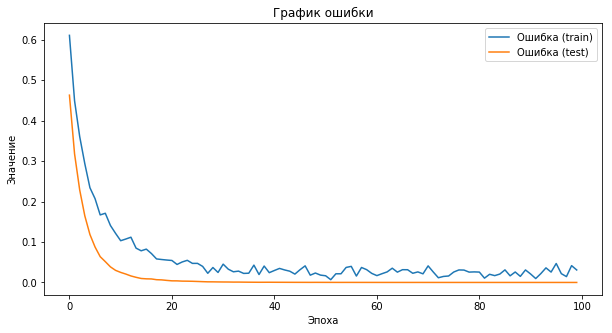

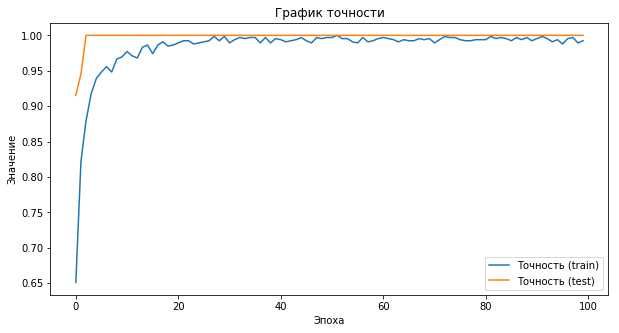

In [22]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

# 6. Контрольные точки
В обучении НС самый последний результат обучения не всегда самый лучший результат, это вызвано несколькими причинами, например переобучением сети или скатыванию к среднему значению.
Для того что бы поймать тот самый лучший результат обучения, были придуманы "контрольные точки" ModelCheckpoint

Для использования контрольных точек необходимо подготовить директорию, где будут хранится контрольные точки

In [25]:
from pathlib import Path
from os import remove

In [26]:
# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [27]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=150,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # Добавляем сценарий ранней остановки
        # Если в течении 30 эпох точность не вырастить более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
#         Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
#             Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
#             Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
#             Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
#             Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=5,
#             Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\TEMP.EDU.027\save_points
Train on 525 samples, validate on 132 samples
Epoch 1/150
525/525 [==============================] - 1s 2ms/step - loss: 0.5596 - categorical_accuracy: 0.6762 - val_loss: 0.4661 - val_categorical_accuracy: 0.9242
Epoch 2/150
525/525 [==============================] - 0s 366us/step - loss: 0.4692 - categorical_accuracy: 0.7886 - val_loss: 0.3699 - val_categorical_accuracy: 0.9545
Epoch 3/150
525/525 [==============================] - 0s 325us/step - loss: 0.3657 - categorical_accuracy: 0.8895 - val_loss: 0.2709 - val_categorical_accuracy: 0.9848
Epoch 4/150
525/525 [==============================] - 0s 311us/step - loss: 0.3005 - categorical_accuracy: 0.9086 - val_loss: 0.2076 - val_categorical_accuracy: 0.9924
Epoch 5/150
525/525 [==============================] - 0s 317us/step - loss: 0.2491 - categorical_accuracy: 0.9276 - val_loss: 0.1564 - val_categorical_accuracy: 0.9924
Epoch 6/150
525

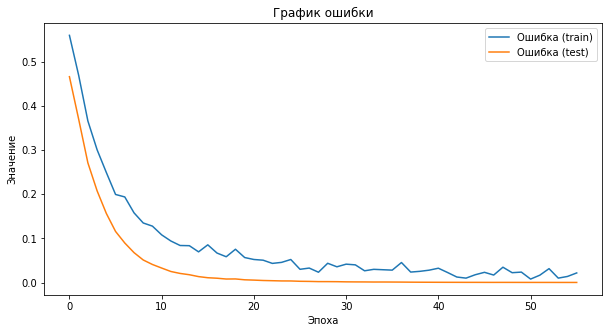

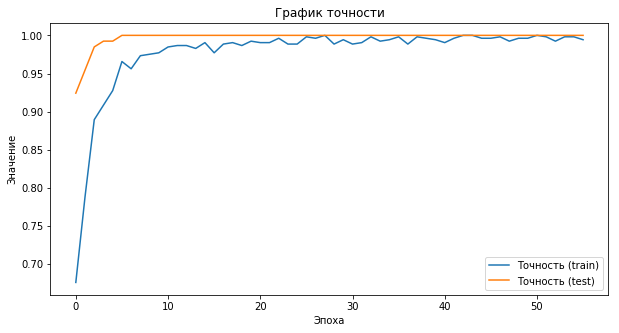

In [28]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [30]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.13_val_loss-0.04_acc-0.98_val_acc-1.00.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

657/657 [==============================] - 0s 263us/step
Точность предсказания на тренировочных данных 1.0
164/164 [==============================] - 0s 24us/step
Точность предсказания на тестовых данных 1.0


array([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [32]:
# Прдсказываем вероятности для классов
loaded_model.predict(X_train)

array([[0.00480969, 0.99519026],
       [0.00458223, 0.99541783],
       [0.77421445, 0.22578557],
       ...,
       [0.0601464 , 0.9398536 ],
       [0.9724426 , 0.02755739],
       [0.97708285, 0.02291711]], dtype=float32)

# Визуализация

In [35]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(821, 2)


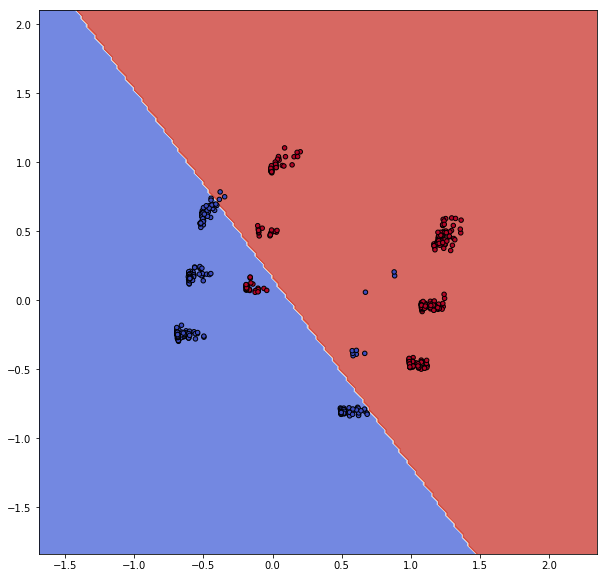

In [36]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_ready_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')